# Load data

In [ ]:
from docx import Document
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
from rapidfuzz.fuzz import partial_ratio
from rapidfuzz.process import extractOne



In [ ]:
def extract_highlighted_text_with_colors(doc_path):
    """
    Extract highlighted text and their corresponding colors from a Word document.
    """
    doc = Document(doc_path)
    data = []

    for paragraph in doc.paragraphs:
        for run in paragraph.runs:
            if run.font.highlight_color:
                color = str(run.font.highlight_color)  # colour info
                text = run.text.strip()
                if text:
                    data.append({'Text': text, 'Color': color})

    return data

doc_paths = {
    "Video A": "/content/VIDEO A.docx",
    "Video B": "/content/VIDEO B.docx",
    "Video C": "/content/VIDEO C.docx",
    "Video D": "/content/VIDEO D.docx",
    "Video E": "/content/VIDEO E.docx",
    "Video F": "/content/VIDEO F.docx"
}


all_highlighted_data = {}

for video, path in doc_paths.items():
    try:
        highlighted_data = extract_highlighted_text_with_colors(path)
        all_highlighted_data[video] = highlighted_data
    except Exception as e:
        all_highlighted_data[video] = f"Error processing {video}: {e}"


highlighted_text_dfs = {}

for video, data in all_highlighted_data.items():
    if isinstance(data, list):
        highlighted_text_dfs[video] = pd.DataFrame(data)
        if not highlighted_text_dfs[video].empty:
            highlighted_text_dfs[video].insert(0, "Video", video)
    else:
        print(data)


combined_highlighted_df = pd.concat(highlighted_text_dfs.values(), ignore_index=True)

print(combined_highlighted_df)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.2 MB/s eta 0:00:00
Error processing Video B: Package not found at '/content/VIDEO B.docx'
Error processing Video D: Package not found at '/content/VIDEO D.docx'
       Video                                               Text       Color
0    Video A  common sense wasn’t already obvious, a man fro...  YELLOW (7)
1    Video A                                              clear  YELLOW (7)
2    Video A                                      in June 2019.  YELLOW (7)
3    Video A          When he stumbled upon what appeared to be  YELLOW (7)
4    Video A                                an empty metal drum  YELLOW (7)
..       ...                                                ...         ...
631  Video F                                               But,    PINK (5)
632  Video F                                      while the DIY    PINK (5)
633  Video F  amputation was being performed, extreme blood ...    PINK (5)
634  Video F      

# Extracting text according to coloured structure

In [ ]:
def consolidate_highlighted_text(dataframe):
    consolidated_data = []
    current_text = ""
    current_color = None
    current_video = None

    for _, row in dataframe.iterrows():
        if current_color is None or current_video is None:
            current_text = row['Text']
            current_color = row['Color']
            current_video = row['Video']
        elif row['Color'] == current_color and row['Video'] == current_video:
            current_text += " " + row['Text']
        else:
            consolidated_data.append({
                "Text": current_text.strip(),
                "Color": current_color,
                "Video": current_video
            })
            current_text = row['Text']
            current_color = row['Color']
            current_video = row['Video']

    if current_text:
        consolidated_data.append({
            "Text": current_text.strip(),
            "Color": current_color,
            "Video": current_video
        })

    return pd.DataFrame(consolidated_data)


consolidated_df = consolidate_highlighted_text(combined_highlighted_df )


output_file_path = "/content/Highlighted_Text_Structured.csv"
consolidated_df.to_csv(output_file_path, index=False)

print(f"Structured data exported to {output_file_path}")
output_file_path


Structured data exported to /content/Highlighted_Text_Structured.csv


'/content/Highlighted_Text_Structured.csv'

# sentimental analysis to check what each colour show emotion

In [ ]:
file_path = "/content/Highlighted_Text_Structured.csv"
data = pd.read_csv(file_path)

# sentiment and emotion analysis pipelines
sentiment_analyzer = pipeline("sentiment-analysis")
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")


results = []
for _, row in tqdm(data.iterrows(), total=len(data)):
    text = row['Text']
    color = row['Color']
    video = row['Video']


    sentiment = sentiment_analyzer(text[:512])[0]  # Limit to 512 tokens

    emotion = emotion_analyzer(text[:512])[0]  # Limit to 512 tokens


    results.append({
        "Text": text,
        "Color": color,
        "Video": video,
        "Sentiment": sentiment['label'],
        "Sentiment Score": sentiment['score'],
        "Emotion": emotion['label'],
        "Emotion Score": emotion['score']
    })


results_df = pd.DataFrame(results)


output_path = "Highlighted_Text_Analysis.csv"
results_df.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu
100%|██████████| 142/142 [00:26<00:00,  5.36it/s]

Results saved to Highlighted_Text_Analysis.csv


# Identify and transform coloured data according to videos , emotion and video %

In [ ]:
import docx
import pandas as pd
import os

file_paths = [
    "/content/VIDEO A.docx",
    "/content/VIDEO B.docx",
    '/content/VIDEO C.docx',
    '/content/VIDEO D.docx',
    '/content/VIDEO E.docx',
    '/content/VIDEO F.docx'
]

video_labels = ["Video A", "Video B", "Video C", "Video D", "Video E", "Video F"]

def extract_text_from_doc(file_path):
    try:
        doc = docx.Document(file_path)
        full_text = []
        for para in doc.paragraphs:
            if para.text.strip():
                full_text.append(para.text.strip())
        return " ".join(full_text)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ""


def segment_text(text, segments=100):
    words = text.split()
    total_words = len(words)
    segment_size = total_words // segments

    segmented_data = []
    for i in range(segments):
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size if i < segments - 1 else total_words
        segment_text = " ".join(words[start_idx:end_idx])
        segmented_data.append({"Video Position (%)": i, "Segment Text": segment_text})

    return segmented_data


all_segmented_data = []
for file_path, video_label in zip(file_paths, video_labels):
    text = extract_text_from_doc(file_path)
    if text:
        segmented_data = segment_text(text)
        for segment in segmented_data:
            segment["Video"] = video_label
        all_segmented_data.extend(segmented_data)

segmented_df = pd.DataFrame(all_segmented_data)


output_path = '/content/Segmented_Video_Scripts.csv'
segmented_df.to_csv(output_path, index=False)

print(f"Segmented scripts saved to {output_path}")


Segmented scripts saved to /content/Segmented_Video_Scripts.csv


# analysing data and checking emotions generating from texts

In [ ]:


segmented_scripts_path = "/content/Segmented_Video_Scripts.csv"
highlighted_text_path = "/content/Highlighted_Text_Analysis.csv"
output_path = "/content/Structured_Highlighted_Text_Analysis.csv"

segmented_scripts = pd.read_csv(segmented_scripts_path)
highlighted_text = pd.read_csv(highlighted_text_path)

segmented_scripts.columns = ['Video position (%)', 'Segment Text', 'Video']
highlighted_text.columns = ['Text', 'Color', 'Video', 'Sentiment', 'Sentiment Score', 'Emotion', 'Emotion Score']


highlighted_text['Video position (%)'] = None

for video in highlighted_text['Video'].unique():
    script_data = segmented_scripts[segmented_scripts['Video'] == video]

    for idx, row in highlighted_text.iterrows():
        if row['Video'] == video:
            matched_segment = script_data[
                script_data['Segment Text'].str.contains(row['Text'], na=False, regex=False)
            ]
            if not matched_segment.empty:
                highlighted_text.at[idx, 'Video position (%)'] = matched_segment['Video position (%)'].values[0]


unmatched = highlighted_text[highlighted_text['Video position (%)'].isnull()]
if not unmatched.empty:
    unmatched_path = "/content/Unmatched_Highlighted_Text.csv"
    unmatched.to_csv(unmatched_path, index=False)
    print(f"Unmatched rows: {len(unmatched)}")
    print(f"Unmatched rows saved to: {unmatched_path}")


structured_data = highlighted_text.pivot_table(
    index='Video position (%)',
    columns='Color',
    values='Text',
    aggfunc=lambda x: ' '.join(x)
).reset_index()


emotion_data = highlighted_text.groupby(['Video position (%)', 'Color']).agg({
    'Emotion': 'first',
    'Sentiment': 'first'
}).reset_index()

# Merge structured data with emotion and sentiment
final_data = pd.merge(structured_data, emotion_data, on='Video position (%)', how='left')

final_data.to_csv(output_path, index=False)
print(f"Structured highlighted text analysis saved to: {output_path}")


Unmatched rows: 119
Unmatched rows saved to: /content/Unmatched_Highlighted_Text.csv
Structured highlighted text analysis saved to: /content/Structured_Highlighted_Text_Analysis.csv


In [ ]:

def process_file(file_path, video_label):

    df = pd.read_excel(file_path, sheet_name="All")

    df = df.dropna(axis=1, how='all')  # Drop fully empty columns

    df = df[df["Video position (%)"].apply(lambda x: str(x).isdigit())]

    df["Video position (%)"] = df["Video position (%)"].astype(int)

    df = df.rename(columns={"Absolute audience retention (%)": f"Audience Retention ({video_label})"})

    return df[["Video position (%)", f"Audience Retention ({video_label})"]]


files = [
    '/content/VIDEO A.xlsx',
    '/content/VIDEO B.xlsx',
    '/content/VIDEO C.xlsx',
    '/content/VIDEO D.xlsx',
    '/content/VIDEO E.xlsx',
    '/content/VIDEO F.xlsx'
]
labels = ["A", "B", "C", "D", "E", "F"]


final_df = None
for file, label in zip(files, labels):
    processed_df = process_file(file, label)
    if final_df is None:
        final_df = processed_df
    else:
        final_df = pd.merge(final_df, processed_df, on="Video position (%)", how="outer")


final_df.to_csv("Combined_Audience_Retention.csv", index=False)
print("Combined data saved to 'Combined_Audience_Retention.csv'.")




Combined data saved to 'Combined_Audience_Retention.csv'.


# Graph of coloured data trends for audience retention and video %

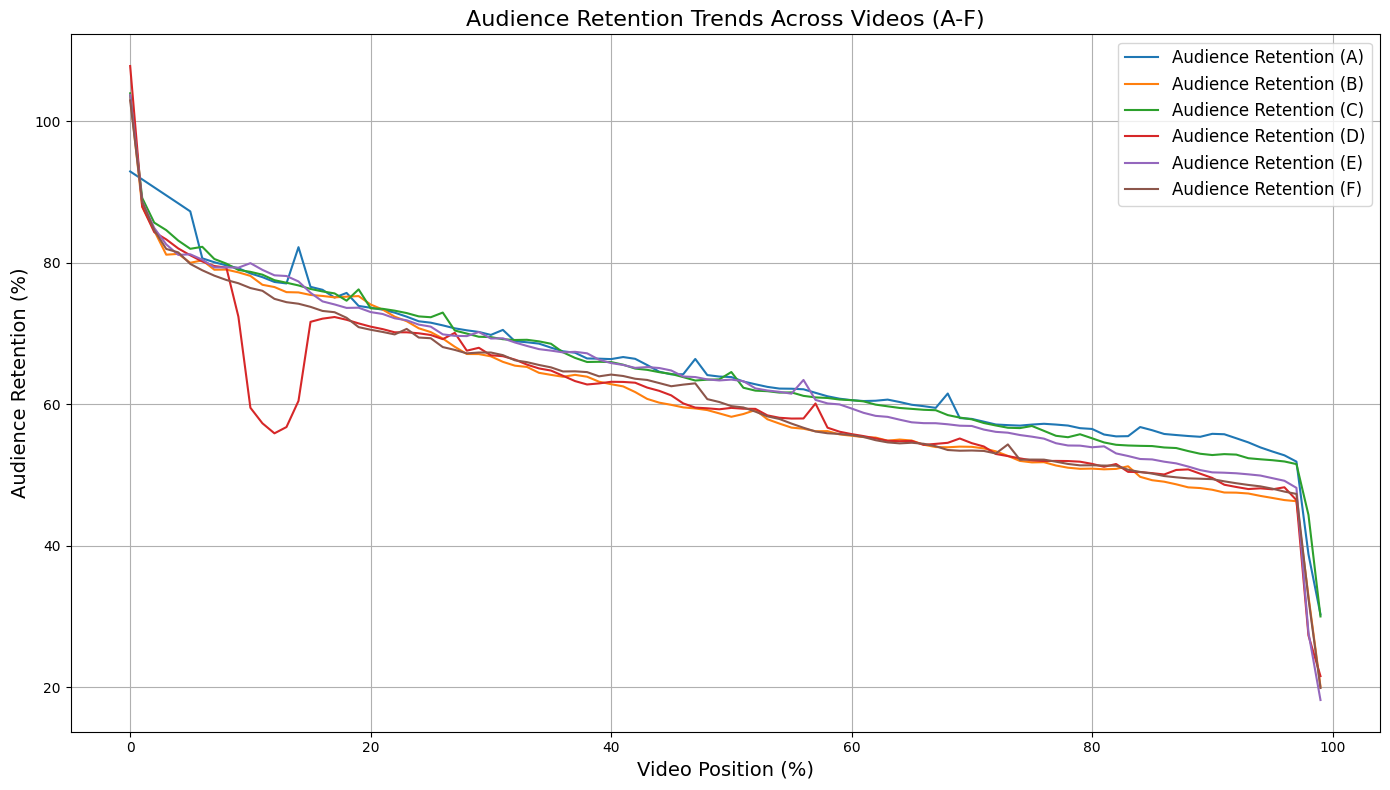

In [ ]:
import matplotlib.pyplot as plt


file_path = "/content/Combined_Audience_Retention.csv"
combined_data = pd.read_csv(file_path)

plt.figure(figsize=(14, 8))

for column in combined_data.columns[1:]:
    plt.plot(combined_data["Video position (%)"], combined_data[column], label=column)


plt.title("Audience Retention Trends Across Videos (A-F)", fontsize=16)
plt.xlabel("Video Position (%)", fontsize=14)
plt.ylabel("Audience Retention (%)", fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.grid(True)
plt.tight_layout()


plt.show()

# ANALYSING ALL DATA


In [ ]:
import pandas as pd


audience_retention_path = "/content/Combined_Audience_Retention.csv"
highlighted_text_path = "/content/Highlighted_Text_Analysis.csv"
segmented_scripts_path = "/content/Segmented_Video_Scripts.csv"
output_path = "/content/Highlighted_Text_Retention_Analysis_Corrected.csv"

# Load datasets
audience_retention = pd.read_csv(audience_retention_path)
highlighted_text = pd.read_csv(highlighted_text_path)
segmented_scripts = pd.read_csv(segmented_scripts_path)


audience_retention.columns = [
    "Video position (%)",
    "Audience Retention (A)",
    "Audience Retention (B)",
    "Audience Retention (C)",
    "Audience Retention (D)",
    "Audience Retention (E)",
    "Audience Retention (F)",
]
highlighted_text.columns = [
    "Text",
    "Color",
    "Video",
    "Sentiment",
    "Sentiment Score",
    "Emotion",
    "Emotion Score",
]
segmented_scripts.columns = ["Video position (%)", "Segment Text", "Video"]


highlighted_text["Video position (%)"] = None


def fuzzy_match(text, segments):
    result = extractOne(text, segments, scorer=partial_ratio)
    return result[0] if result and result[1] > 80 else None

for video in highlighted_text["Video"].unique():
    script_data = segmented_scripts[segmented_scripts["Video"] == video]

    for idx, row in highlighted_text.iterrows():
        if row["Video"] == video and pd.isna(row["Video position (%)"]):
            matched_segment = script_data[
                script_data["Segment Text"].str.contains(row["Text"], na=False, regex=False)
            ]
            if not matched_segment.empty:
                highlighted_text.at[idx, "Video position (%)"] = matched_segment[
                    "Video position (%)"
                ].values[0]
            else:
                matched_segment_text = fuzzy_match(row["Text"], script_data["Segment Text"].tolist())
                if matched_segment_text:
                    matched_row = script_data[
                        script_data["Segment Text"] == matched_segment_text
                    ]
                    highlighted_text.at[idx, "Video position (%)"] = matched_row[
                        "Video position (%)"
                    ].values[0]


highlighted_text = highlighted_text.dropna(subset=["Video position (%)"])
highlighted_text["Video position (%)"] = highlighted_text["Video position (%)"].astype(int)

video_mapping = {
    "Video A": "Audience Retention (A)",
    "Video B": "Audience Retention (B)",
    "Video C": "Audience Retention (C)",
    "Video D": "Audience Retention (D)",
    "Video E": "Audience Retention (E)",
    "Video F": "Audience Retention (F)",
}

highlighted_text["Audience Retention (%)"] = highlighted_text.apply(
    lambda row: audience_retention.loc[
        audience_retention["Video position (%)"] == row["Video position (%)"],
        video_mapping[row["Video"]],
    ].values[0],
    axis=1,
)


highlighted_text.to_csv(output_path, index=False)
print(f"Corrected highlighted text retention analysis saved to: {output_path}")


Corrected highlighted text retention analysis saved to: /content/Highlighted_Text_Retention_Analysis_Corrected.csv


<ipython-input-32-98d1cf5738ca>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highlighted_text["Video position (%)"] = highlighted_text["Video position (%)"].astype(int)
<ipython-input-32-98d1cf5738ca>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highlighted_text["Audience Retention (%)"] = highlighted_text.apply(


# Exploratory data analysis (final data)

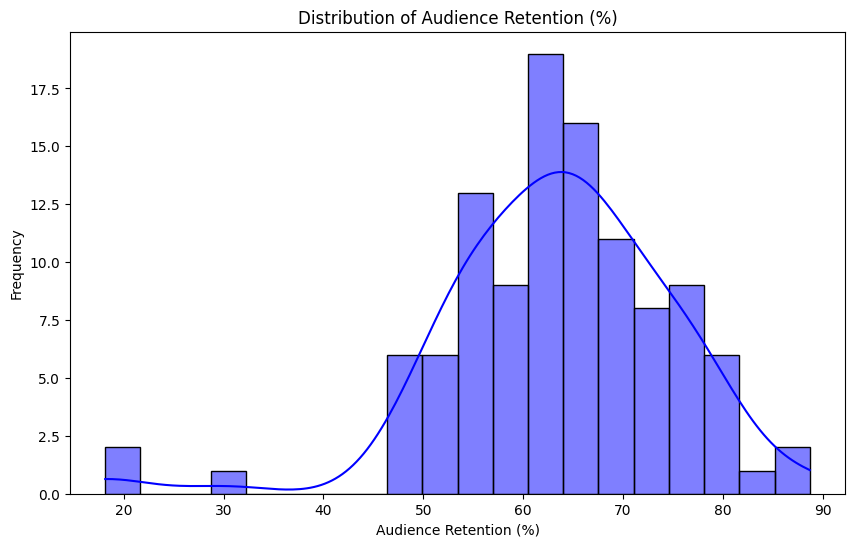

<ipython-input-38-b3b037bd6d3c>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="Emotion", order=data['Emotion'].value_counts().index, palette="Set2")


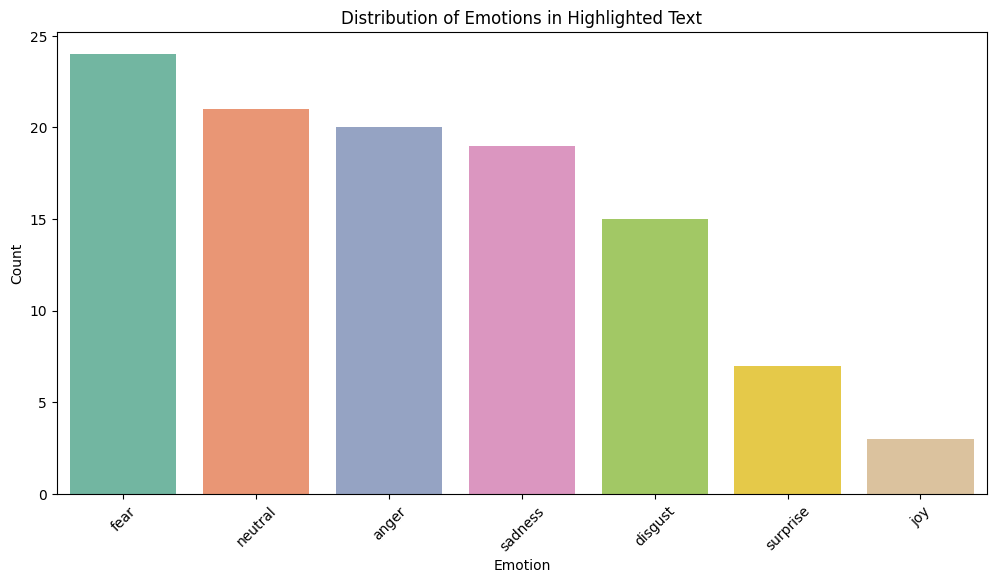

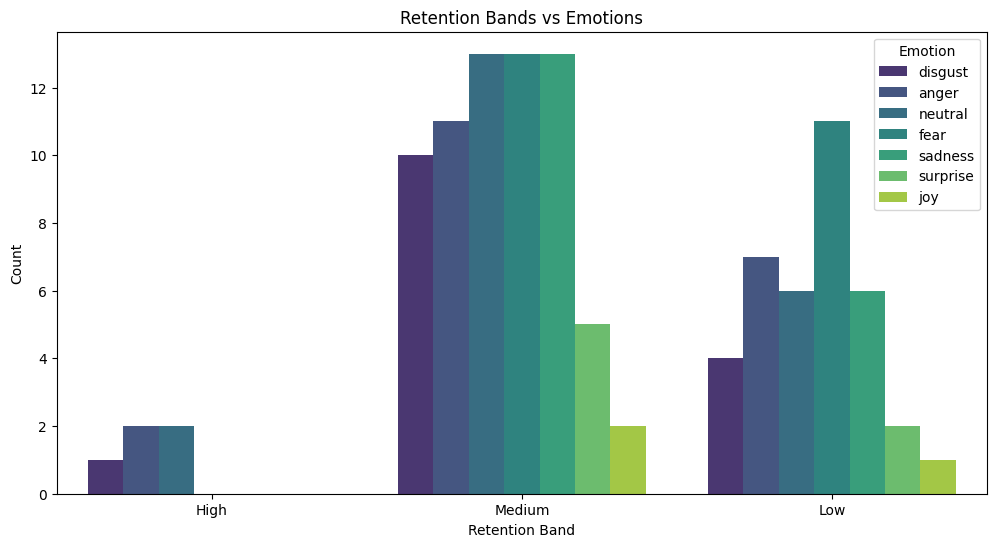

<ipython-input-38-b3b037bd6d3c>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Video", y="Audience Retention (%)", palette="Set3")


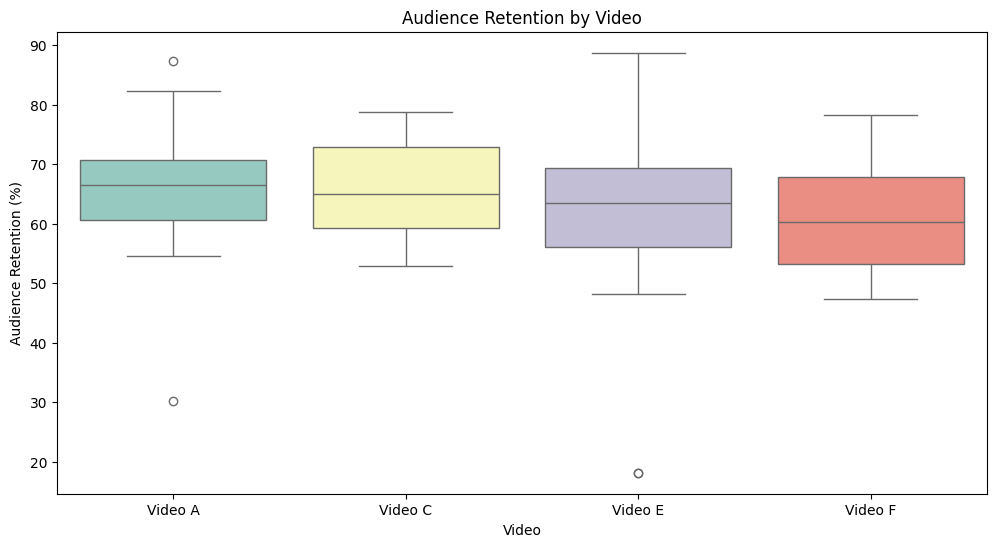


High retention outliers:
                                                 Text  Emotion  \
66                                                  .  neutral   
0   common sense wasn’t already obvious, a man fro...  disgust   
2   ? It would seem so, because he clearly placed ...  neutral   
54  he made his first dumb move: crash ing into a ...    anger   
1   the inquisitive fellow thought best to cut the...    anger   

    Audience Retention (%)    Video  
66                   88.70  Video E  
0                    87.27  Video A  
2                    82.21  Video A  
54                   80.44  Video E  
1                    80.08  Video A  

Low retention outliers:
                                                  Text  Emotion  \
81   were trapped in their car after it failed to m...     fear   
82                          They sank and soon drowned  sadness   
28   But to make matters worse, the combination of ...     fear   
108  . But, while the DIY amputation was being perf...  

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


highlighted_text_retention_path = "/content/Highlighted_Text_Retention_Analysis_Corrected.csv"

data = pd.read_csv(highlighted_text_retention_path)

data.columns = [
    'Text', 'Color', 'Video', 'Sentiment', 'Sentiment Score', 'Emotion',
    'Emotion Score', 'Video position (%)', 'Audience Retention (%)'
]

data['Audience Retention (%)'] = pd.to_numeric(data['Audience Retention (%)'], errors='coerce')

# Plot distribution of audience retention
plt.figure(figsize=(10, 6))
sns.histplot(data['Audience Retention (%)'], kde=True, bins=20, color="blue")
plt.title("Distribution of Audience Retention (%)")
plt.xlabel("Audience Retention (%)")
plt.ylabel("Frequency")
plt.show()

# Plot distribution of emotions
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x="Emotion", order=data['Emotion'].value_counts().index, palette="Set2")
plt.title("Distribution of Emotions in Highlighted Text")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Group retention into bands
def categorize_retention(value):
    if value < 60:
        return "Low"
    elif 60 <= value <= 80:
        return "Medium"
    else:
        return "High"

data['Retention Band'] = data['Audience Retention (%)'].apply(categorize_retention)

# Plot retention bands vs emotions
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x="Retention Band", hue="Emotion", palette="viridis")
plt.title("Retention Bands vs Emotions")
plt.xlabel("Retention Band")
plt.ylabel("Count")
plt.show()

# Analyze audience retention by video
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x="Video", y="Audience Retention (%)", palette="Set3")
plt.title("Audience Retention by Video")
plt.xlabel("Video")
plt.ylabel("Audience Retention (%)")
plt.show()


high_retention_outliers = data.nlargest(5, 'Audience Retention (%)')[
    ['Text', 'Emotion', 'Audience Retention (%)', 'Video']
]
low_retention_outliers = data.nsmallest(5, 'Audience Retention (%)')[
    ['Text', 'Emotion', 'Audience Retention (%)', 'Video']
]

print("\nHigh retention outliers:")
print(high_retention_outliers)

print("\nLow retention outliers:")
print(low_retention_outliers)


# Train model for audience retention predictions


In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from transformers import pipeline

# Load pretrained models for sentiment and emotion
emotion_analyzer = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion")
sentiment_analyzer = pipeline("sentiment-analysis")


data_path = "/content/Highlighted_Text_Retention_Analysis_Corrected.csv"
data = pd.read_csv(data_path)

# Feature Engineering
data['Text Length'] = data['Text'].apply(len)  # Text length as a numerical feature
data['Trend'] = data['Video position (%)'] / 100  # Trend as a feature


features = ['Sentiment Score', 'Emotion Score', 'Text Length', 'Trend', 'Emotion']
target = 'Audience Retention (%)'

X = data[features]
y = data[target]

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['Emotion']),  # Encode categorical 'Emotion'
        ('scaler', StandardScaler(), ['Sentiment Score', 'Emotion Score', 'Text Length', 'Trend'])
    ]
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=200, random_state=42))
])

model_pipeline.fit(X_train, y_train)


y_pred = model_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-Squared (R²): {r2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


new_intro_text = """We all want to leave a memorable mark on the world, but not everyone gets it right. Imagine moments so absurd, they’re almost unbelievable — the kind of tales that make you laugh, gasp, or shake your head in disbelief. Today, we’re diving into some of the most hilariously bizarre and jaw-droppingly unexpected ways people have met their end. Curious? Let’s explore these unforgettable and wildly entertaining stories together!"""

emotion_results = emotion_analyzer(new_intro_text)
sentiment_results = sentiment_analyzer(new_intro_text)


top_emotion = max(emotion_results, key=lambda x: x['score'])
emotion = top_emotion['label']
emotion_score = top_emotion['score']

sentiment_score = sentiment_results[0]['score']

# Prepare the new intro data
new_intro_features = pd.DataFrame([{
    'Sentiment Score': sentiment_score,
    'Emotion Score': emotion_score,
    'Text Length': len(new_intro_text),
    'Trend': 0.05,
    'Emotion': emotion
}])


predicted_retention = model_pipeline.predict(new_intro_features)

print(f"Predicted Audience Retention for New Intro: {predicted_retention[0]:.2f}%")

Device set to use cpu
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Mean Absolute Error (MAE): 1.68
R-Squared (R²): 0.97
Root Mean Squared Error (RMSE): 2.25
Predicted Audience Retention for New Intro: 79.67%
